In [52]:
from argparse import Namespace
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns

from jax.nn import softmax
from jax.config import config
from pathlib import Path
from collections import namedtuple

config.update('jax_platform_name', 'cpu')
np.set_printoptions(precision=4)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 18})

from grl.utils import load_info
from grl.utils.mdp import all_t_discounted_returns
from grl.utils.data import uncompress_episode_rewards
from grl.utils.loss import mse
from grl.environment import get_env

from definitions import ROOT_DIR

In [86]:
results_dir_td = Path(ROOT_DIR, 'results', 'popgym_sweep_td')
results_dir_mc = Path(ROOT_DIR, 'results', 'popgym_sweep_mc')
results_dir_split = Path(ROOT_DIR, 'results', 'rnn_split')

to_plot = 'MC'  # (TD | MC | both)

In [87]:
results_path = list(results_dir_mc.iterdir())[4]
info = load_info(results_path)

info['episodes_info']['online_info'].keys()

dict_keys(['total_episode_loss', 'episode_updates', 'episode_returns', 'discounted_returns'])

In [88]:
# import sys

# def get_size(obj, seen=None):
#     """Recursively finds size of objects"""
#     size = sys.getsizeof(obj)
#     if seen is None:
#         seen = set()
#     obj_id = id(obj)
#     if obj_id in seen:
#         return 0
#     # Important mark as seen *before* entering recursion to gracefully handle
#     # self-referential objects
#     seen.add(obj_id)
#     if isinstance(obj, dict):
#         size += sum([get_size(v, seen) for v in obj.values()])
#         size += sum([get_size(k, seen) for k in obj.keys()])
#     elif hasattr(obj, '__dict__'):
#         size += get_size(obj.__dict__, seen)
#     elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
#         size += sum([get_size(i, seen) for i in obj])
#     return size

# print(f"{results_path.stem}: {get_size(dict_to_test) / 1000000:.2f}MB")

In [89]:

offline_eval = []
if to_plot == 'TD':
    all_results_paths = list(results_dir_td.iterdir())
elif to_plot == 'MC':
    all_results_paths = list(results_dir_mc.iterdir())
elif to_plot == 'both':
    all_results_paths = list(results_dir_td.iterdir()) + list(results_dir_mc.iterdir())
else:
    raise NotImplementedError

# all_results_paths = list(results_dir_split.iterdir())

for results_path in tqdm(all_results_paths):
    if results_path.is_dir() or results_path.suffix != '.npy':
        continue
    
    info = load_info(results_path)
    args = Namespace(**info['args'])

    # if (args.multihead_loss_mode != 'both') and (args.multihead_lambda_coeff > 0.):
    #     continue

    no_gamma_terminal = not args.no_gamma_terminal

    offline_evals = info['episodes_info']['offline_eval']
    eval_freq = args.offline_eval_freq
    total_steps = args.total_steps
    env = get_env(args)
    if not hasattr(env, 'gamma'):
        env.gamma = args.gamma
    reward_scale = 1.
    normalize_rewards = args.normalize_rewards
    if args.normalize_rewards:
        assert hasattr(env, 'R_max') and hasattr(env, 'R_min')
        reward_scale = 1 / (env.R_max - env.R_min)

    all_t_undisc_returns = []

    # For each offline eval
    for i, oe in enumerate(offline_evals):
        d = {**info['args']}

        avg_undisc_returns = 0
        avg_value_err = 0
        
        n_returns = oe['episode_returns']
        n_q_errs = oe['episode_q_errs']
        n_discounted_returns = oe['episode_discounted_returns']

        d['timestep'] = int(i * eval_freq)
        d['undisc_returns'] = n_returns.mean()
        d['value_err'] = n_q_errs.mean()
    
        offline_eval.append(d)

all_res_df = pd.DataFrame(offline_eval)



  0%|          | 0/540 [00:00<?, ?it/s]

In [90]:
arch = "gru"
measure_col = 'undisc_returns'
all_args = list(info['args'].keys())

offline_eval_df = all_res_df[
    (all_res_df['arch'] == arch)
    & (all_res_df['multihead_lambda_coeff'] >= 0.)
#     & (all_res_df['multihead_lambda_coeff'] != 1.)
#     & (all_res_df['multihead_loss_mode'] != 'td')
#     & (all_res_df['multihead_action_mode'] == 'td')
]

unique_seeds = offline_eval_df.seed.unique()

split_by_args = ['spec', 'multihead_action_mode', 'multihead_loss_mode', 'multihead_lambda_coeff', 'lr']

# For split exp
# split_by_args = ['spec', 'multihead_loss_mode', 'lr']

rnn_grouped = offline_eval_df.groupby(split_by_args, as_index=False)

In [91]:
all_res_df

,spec,no_gamma_terminal,gamma,max_episode_steps,feature_encoding,algo,arch,epsilon,lr,optimizer,...,offline_eval_epsilon,checkpoint_freq,save_all_checkpoints,total_steps,platform,seed,study_name,timestep,undisc_returns,value_err
0,popgym-LabyrinthEscapeEasy-v0,True,0.99,1000,none,multihead_rnn,gru,0.1,0.000001,adam,...,0.1,-1,False,15000000,cpu,2020,popgym_sweep_mc,0,-0.807617,0.197754
1,popgym-LabyrinthEscapeEasy-v0,True,0.99,1000,none,multihead_rnn,gru,0.1,0.000001,adam,...,0.1,-1,False,15000000,cpu,2020,popgym_sweep_mc,50000,-0.838867,0.238892
2,popgym-LabyrinthEscapeEasy-v0,True,0.99,1000,none,multihead_rnn,gru,0.1,0.000001,adam,...,0.1,-1,False,15000000,cpu,2020,popgym_sweep_mc,100000,-0.706055,0.218506
3,popgym-LabyrinthEscapeEasy-v0,True,0.99,1000,none,multihead_rnn,gru,0.1,0.000001,adam,...,0.1,-1,False,15000000,cpu,2020,popgym_sweep_mc,150000,-0.838867,0.174316
4,popgym-LabyrinthEscapeEasy-v0,True,0.99,1000,none,multihead_rnn,gru,0.1,0.000001,adam,...,0.1,-1,False,15000000,cpu,2020,popgym_sweep_mc,200000,-0.816895,0.220947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161995,popgym-AutoencodeEasy-v0,True,0.99,1000,none,multihead_rnn,gru,0.1,0.000100,adam,...,0.1,-1,False,15000000,cpu,2022,popgym_sweep_mc,14750000,-0.399902,0.001953
161996,popgym-AutoencodeEasy-v0,True,0.99,1000,none,multihead_rnn,gru,0.1,0.000100,adam,...,0.1,-1,False,15000000,cpu,2022,popgym_sweep_mc,14800000,-0.465332,0.001523
161997,popgym-AutoencodeEasy-v0,True,0.99,1000,none,multihead_rnn,gru,0.1,0.000100,adam,...,0.1,-1,False,15000000,cpu,2022,popgym_sweep_mc,14850000,-0.434570,0.002258
161998,popgym-AutoencodeEasy-v0,True,0.99,1000,none,multihead_rnn,gru,0.1,0.000100,adam,...,0.1,-1,False,15000000,cpu,2022,popgym_sweep_mc,14900000,-0.423096,0.001111


In [92]:
# take mean and std_err over mean over seeds
rnn_mean = rnn_grouped.mean(numeric_only=True)
rnn_sem = rnn_grouped.sem(numeric_only=True)

# Now we take the max over everything but learning rate
max_over_args = ['lr']
grouped_args = [arg for arg in split_by_args if arg not in max_over_args]
rnn_less_lr_grouped = rnn_mean.groupby(grouped_args, as_index=False)

rnn_arg_maxes = rnn_mean.sort_values(measure_col).drop_duplicates(grouped_args, keep='last')

In [93]:
# drop columns we need in original df
pruned_rnn_arg_maxes = rnn_arg_maxes.drop(columns=['timestep', 'seed'])

# A df of results over all the maxes.
max_offline_eval_df = pruned_rnn_arg_maxes.merge(offline_eval_df, on=split_by_args, how='inner')


In [94]:
w = 5
mode = 'same'

max_offline_eval_df[f'avged_returns'] = max_offline_eval_df.groupby(split_by_args)['undisc_returns_y'].transform(lambda x: np.convolve(x, np.ones(w), mode=mode) / w)

# max_offline_eval_df = max_offline_eval_df[(max_offline_eval_df['timestep'] > w * eval_freq) &
#                                          (max_offline_eval_df['timestep'] < w * eval_freq)]

In [95]:
# max_offline_eval_df['timestep'].max()

In [96]:
df = max_offline_eval_df
# pivot_value_key = 'undisc_returns_y'
pivot_value_key = 'avged_returns'

# pivot_value_key = 'value_err_y'


# df = offline_eval_df
# pivot_value_key = 'undisc_returns'

all_labels = \
    sorted(['_'.join([str(el) for el in row]) for row in df[[arg for arg in grouped_args if (arg != 'spec') and (arg != 'timestep')]]\
        .drop_duplicates()\
        .to_numpy()])

label_cmap = {}

color = iter(cm.tab10(np.linspace(0, 1, 10)))
for i in range(len(all_labels)):
    c = next(color)
    label_cmap[all_labels[i]] = c

In [97]:
all_labels

['mc_both_0.0', 'mc_both_1.0', 'mc_mc_0.0']

  0%|          | 0/15 [00:00<?, ?it/s]

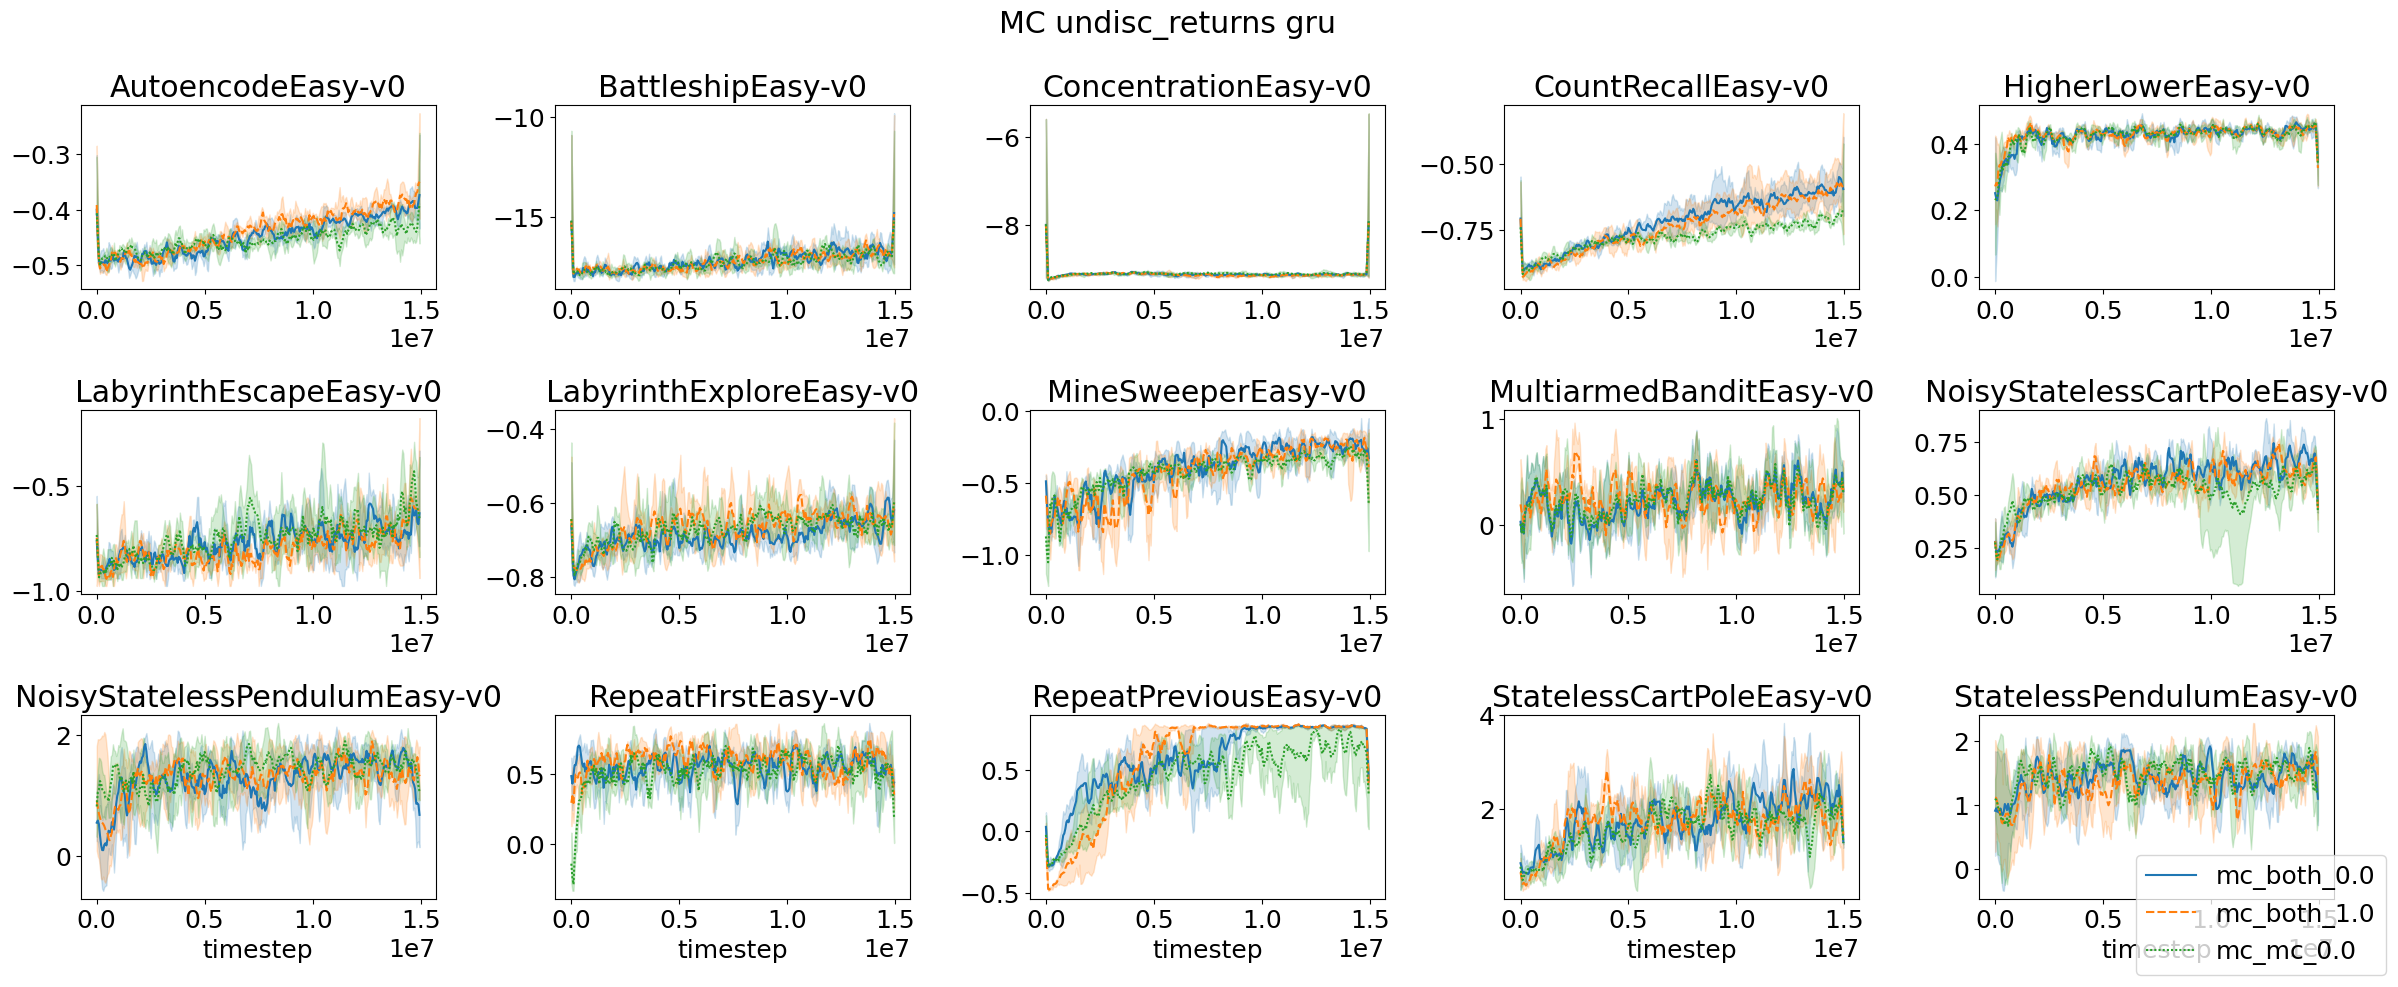

In [98]:
spec_strs = df['spec'].unique()

pivot_cols = [arg for arg in grouped_args if (arg != 'spec') and (arg != 'timestep')] + ['seed']

n_specs = len(spec_strs)

n_rows = 3
n_cols = np.ceil(n_specs / n_rows).astype(int)

if n_specs == 1:
    n_rows = 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 10))

for i, spec in tqdm(list(enumerate(sorted(spec_strs)))):
    row = i // n_cols
    col = i % n_cols
    
    ax = axes
    if n_specs > 1:
        ax = axes[row, col]

    spec_df = df[df['spec'] == spec]
    sorted_spec_df = spec_df.sort_values(by=grouped_args)
    
    # Make a pivot table
    pivot_df = sorted_spec_df.pivot(index='timestep', columns=pivot_cols, values=pivot_value_key)
    
    # Flatten all columns except seed
    col_name = '_'.join([col for col in pivot_cols if col != 'seed'])
    multi_index = pd.MultiIndex.from_tuples([('_'.join([str(c) for c in col[:-1]]), col[-1]) for col in pivot_df.columns], names=[col_name, "seed"])

    pivot_df.columns = multi_index

    sns.lineplot(ax=ax, data=pivot_df, palette=label_cmap)
    
    ax.get_legend().remove()
    title = spec
    if 'popgym-' in spec:
        title = spec.replace('popgym-', '')
        
    ax.set_title(title)
    if col > 0:
        ax.set_ylabel(None)
    if row < n_rows - 1:
        ax.set_xlabel(None)
        
    handles, labels = ax.get_legend_handles_labels()
    
    if spec == 'rocksample':
        ax.set_ylim(0, 35)
        step_per_eval = 1000
        ax.set_xlim(w * step_per_eval // 2, df['timestep'].max() - w * step_per_eval // 2)
#     if i >= 1:
#         break
        
fig.legend(handles, labels, loc='lower right')
fig.suptitle(f"{to_plot} {measure_col} {arch}")
fig.tight_layout()

In [99]:
fig_path = Path(ROOT_DIR, 'results', f'popgym_{measure_col}_{arch}_rnn_{to_plot}.pdf')
fig.savefig(fig_path, bbox_inches='tight')

In [ ]:
# for results_path in tqdm(all_results_paths):
#     if results_path.is_dir() or results_path.suffix != '.npy':
#         continue
    
#     info = load_info(results_path)
#     args = info['args']
#     if args['multihead_lambda_coeff'] == -1:
#         results_path.unlink()

In [ ]:
()